In [1]:
%%time
%reset -f

import pandas as pd
from rdkit.Chem import AllChem, Draw, Descriptors   
from rdkit import Chem, DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import rdMolDescriptors
from rdkit.DataStructs import ExplicitBitVect

curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

molecule_names = ['2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-14-Moore', 'AD-16-DMF', 'AD-18', 'AD-24', 'AD-25', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-9', 'YD-30']
homo_lumo_gap = [3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 2.811, 3.231, 2.735, 2.878, 2.686, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 3.137, 2.525]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame of Curcumin
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)

def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception:
        return None
    return None

# apply morgan fingerprint to the curcumin_df dataframe
curcumin_df['Morgan_Fingerprints'] = curcumin_df['Smiles'].apply(generate_morgan_fingerprint_safe)
curcumin_df = curcumin_df[curcumin_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_df = pd.DataFrame(curcumin_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

curcumin_df_mf = pd.concat([curcumin_df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)

# Convert any fingerprint to a bit vector
def convert_to_bit_vector(fp, nBits=2048):
    bit_vector = ExplicitBitVect(nBits)
    for bit in fp.GetNonzeroElements().keys():
        bit_vector.SetBit(bit % nBits)
    return bit_vector

# Atom pair Fingerprint bit vector conversion
def generate_atom_pair_fingerprint(mol, nBits=2048):
    fp = rdMolDescriptors.GetAtomPairFingerprint(mol)
    return convert_to_bit_vector(fp, nBits)

# Function to generate fingerprints
def generate_fingerprint(mol, fp_type, radius=2, n_bits=2048):
    if fp_type == 'morgan':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, useChirality=True)
    elif fp_type == 'fcfp':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=n_bits, useChirality=True)
    elif fp_type == 'atom_pair':
        return generate_atom_pair_fingerprint(mol, nBits=n_bits)

# Similarity functions
def calculate_similarity(fp1, fp2, metric):
    if metric == 'tanimoto':
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    elif metric == 'dice':
        return DataStructs.DiceSimilarity(fp1, fp2)
    elif metric == 'cosine':
        return DataStructs.CosineSimilarity(fp1, fp2)
    elif metric == 'kulczynski':
        return DataStructs.KulczynskiSimilarity(fp1, fp2)

curcumin_similarity_variants = {
    "seg01" : "Cc2ccc(/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1)cc2",
    "seg02" : "C/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1",
    "seg03" : "C/C=C/C(=O)CC(=O)/C=C/C",
    "seg04" : "Cc1ccc(/C=C/C=O)cc1",
    "seg05" : "C/C=C/C=O",
    "seg06" : "C/C=C/C1=CC(/C=C/C)=[O+][B-](F)(F)O1",
}

# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=[
    'index', 'inchikey', 'LUMO_calib_stds', 'HOMO_calib_stds',
    'molW', 'PCE_calc', 'Voc_calc', 'Jsc_calc',
    'FF_calc', 'EQE_calc', 'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib',
    'EQE_calib', 'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df['mol'] = opv_df['smiles'].apply(Chem.MolFromSmiles)

opv_df_sorted = opv_df.sort_values(by='LUMO_calc')
opv_df_filtered = opv_df_sorted[opv_df_sorted['LUMO_calc'] <= -3.5]
opv_df_filtered.reset_index(drop=True, inplace=True)

# Dictionary to hold the dataframes
similarity_dfs = {}

# Fingerprints and similarity methods
fingerprints = ['morgan', 'atom_pair']
similarities = ['tanimoto', 'cosine', 'kulczynski', 'dice']

# Loop over curcumin segments, fingerprints, and similarities
for key, smiles in curcumin_similarity_variants.items():
    specific_mol = Chem.MolFromSmiles(smiles)
    
    for fp_type in fingerprints:
        specific_fp = generate_fingerprint(specific_mol, fp_type)
        
        for sim_metric in similarities:
            opv_df_sim_segment = opv_df_filtered.copy()
            opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment['mol'].apply(lambda x: calculate_similarity(generate_fingerprint(x, fp_type), specific_fp, sim_metric))
            
            # Filter top 48% similar molecules
            quantile_value = opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'].quantile(0.50)
            opv_df_sim_segment = opv_df_sim_segment[opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] >= quantile_value]
            
            # Keep only the relevant columns (initial columns + similarity)
            opv_df_sim_segment = opv_df_sim_segment[['smiles', 'mol', 'GAP_calc', f'similarity_{key}_{fp_type}_{sim_metric}']]
            
            # Store the filtered dataframe in the dictionary
            similarity_dfs[f'{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment

            print(f"Generated dataframe for segment {key}, fingerprint {fp_type}, similarity {sim_metric}: shape {opv_df_sim_segment.shape}")

Generated dataframe for segment seg01, fingerprint morgan, similarity tanimoto: shape (6365, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity cosine: shape (6481, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity kulczynski: shape (6394, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity dice: shape (6365, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity tanimoto: shape (6363, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity cosine: shape (6361, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity kulczynski: shape (6384, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity dice: shape (6363, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity tanimoto: shape (6361, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity cosine: shape (6452, 4)
Generated dataframe for segment seg02,

In [2]:
%%time
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors

# Function to generate Morgan fingerprints safely
def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception as e:
        print(f"Error generating Morgan fingerprint for SMILES {smiles}: {e}")
        return None
    return None

# Dictionary to store processed dataframes
processed_similarity_dfs = {}

# Process each dataframe
for combination, df in similarity_dfs.items():
    print(f"Processing {combination}...")
    df = df.copy()
    
    # Generate Morgan fingerprints
    df['Morgan_Fingerprints'] = df['smiles'].apply(generate_morgan_fingerprint_safe)
    df = df[df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
    
    # Convert Morgan fingerprints to a DataFrame and concatenate with the original
    morgan_df = pd.DataFrame(df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

    df_combined = pd.concat([df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
    
    # Store the combined DataFrame
    processed_similarity_dfs[combination] = df_combined
    print(f"Finished processing {combination} - shape {df_combined.shape}")

# Unpacking the dictionary to individual DataFrames
for combination, df in processed_similarity_dfs.items():
    globals()[f'similarity_dfs_{combination}'] = df

Processing seg01_morgan_tanimoto...
Finished processing seg01_morgan_tanimoto - shape (6365, 2052)
Processing seg01_morgan_cosine...
Finished processing seg01_morgan_cosine - shape (6481, 2052)
Processing seg01_morgan_kulczynski...
Finished processing seg01_morgan_kulczynski - shape (6394, 2052)
Processing seg01_morgan_dice...
Finished processing seg01_morgan_dice - shape (6365, 2052)
Processing seg01_atom_pair_tanimoto...
Finished processing seg01_atom_pair_tanimoto - shape (6363, 2052)
Processing seg01_atom_pair_cosine...
Finished processing seg01_atom_pair_cosine - shape (6361, 2052)
Processing seg01_atom_pair_kulczynski...
Finished processing seg01_atom_pair_kulczynski - shape (6384, 2052)
Processing seg01_atom_pair_dice...
Finished processing seg01_atom_pair_dice - shape (6363, 2052)
Processing seg02_morgan_tanimoto...
Finished processing seg02_morgan_tanimoto - shape (6361, 2052)
Processing seg02_morgan_cosine...
Finished processing seg02_morgan_cosine - shape (6452, 2052)
Proces

___________________________________________________________________
Processing seg02_atom_pair_cosine


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Chamod Peiris\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Chamod Peiris\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 5156, number of used features: 881
[LightGBM] [Info] Start training from score 2.674072
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 5156, number of used features: 881
[LightGBM] [Info] Start training from score 2.674072
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Model seg02_atom_pair_cosine
MAE Value: 0.08012 & RMSE Value: 0.11856
Prediction --> model MAE: 0.10190 & RMSE: 0.13521
Prediction --> model R2 Score: 0.0091
___________________________________________________________________


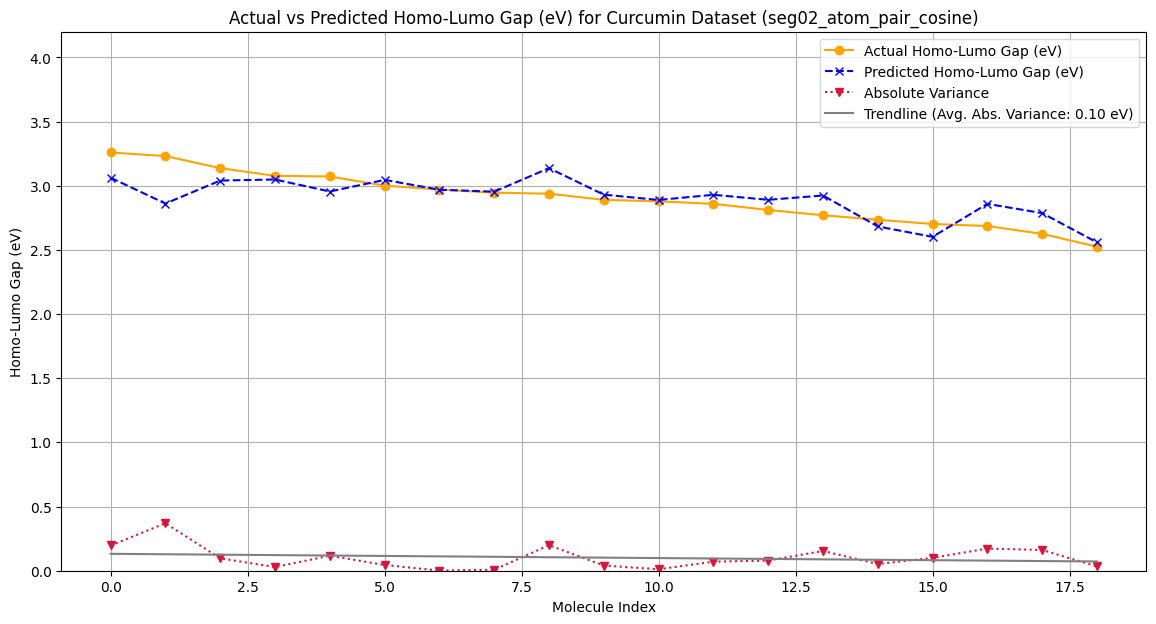

CPU times: total: 6h 21min 38s
Wall time: 25min 18s


In [3]:
%%time

import pandas as pd
from sklearn.feature_selection import RFE
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# List of best models and their corresponding DataFrame keys
best_models_all_segments = [
    "seg02_atom_pair_cosine"
]

# Loop over each model
for model_name in best_models_all_segments:
    print("___________________________________________________________________")
    print(f"Processing {model_name}")
    
    # Load the respective DataFrame
    df = processed_similarity_dfs[model_name]
    X = df.iloc[:, 4:]  # Features from the 4th column onwards
    y = df['GAP_calc']  # Target variable

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # LightGBM parameters and model initialization
    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)

    # RFE for feature selection
    n_features_to_select = 810
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    # Get selected features
    selected_features = X_train.columns[rfe.support_]
    
    # Train the model using the selected features
    model.fit(X_train[selected_features], y_train)
    y_pred_test = model.predict(X_test[selected_features])
    
    # Calculate metrics for the test set
    mae_model = mean_absolute_error(y_test, y_pred_test)
    rmse_model = mean_squared_error(y_test, y_pred_test, squared=False)
    r2_model = model.score(X_test[selected_features], y_test)
    
    print(f"Model {model_name}")
    print(f"MAE Value: {mae_model:.5f} & RMSE Value: {rmse_model:.5f}")
    
    # Predict on the curcumin dataset using the same selected features
    curcumin_X = curcumin_df_mf[selected_features]
    curcumin_df_mf['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_X)

    # Sort by actual Homo-Lumo Gap for visualization
    curcumin_df_mf = curcumin_df_mf.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

    # Calculate evaluation metrics for curcumin predictions
    mae_predict = mean_absolute_error(curcumin_df_mf['Homo-Lumo Gap (eV)'], curcumin_df_mf['Homo-Lumo Gap (eV) Pred'])
    rmse_predict = mean_squared_error(curcumin_df_mf['Homo-Lumo Gap (eV)'], curcumin_df_mf['Homo-Lumo Gap (eV) Pred'], squared=False)
    r2_predict = model.score(curcumin_X, curcumin_df_mf['Homo-Lumo Gap (eV)'])

    print(f"Prediction --> model MAE: {mae_predict:.5f} & RMSE: {rmse_predict:.5f}")
    print(f"Prediction --> model R2 Score: {r2_predict:.4f}")   
    print("___________________________________________________________________")

    # Calculate absolute variance and average variance
    curcumin_df_mf['absolute_variance'] = (curcumin_df_mf['Homo-Lumo Gap (eV)'] - curcumin_df_mf['Homo-Lumo Gap (eV) Pred']).abs()
    average_variance = curcumin_df_mf['absolute_variance'].mean()
    
    # Optional: Plot actual vs predicted for curcumin dataset along with absolute variance
    plt.figure(figsize=(14, 7))

    # Plot actual and predicted values
    plt.plot(curcumin_df_mf['Homo-Lumo Gap (eV)'], label='Actual Homo-Lumo Gap (eV)', marker='o', color='orange')
    plt.plot(curcumin_df_mf['Homo-Lumo Gap (eV) Pred'], label='Predicted Homo-Lumo Gap (eV)', marker='x', linestyle='--', color='blue')

    # Plot absolute variance
    plt.plot(curcumin_df_mf['absolute_variance'], label='Absolute Variance', marker='v', linestyle=':', color='crimson')

    # Plot trendline for absolute variance
    x_vals = np.arange(len(curcumin_df_mf))
    trendline = np.polyval(np.polyfit(x_vals, curcumin_df_mf['absolute_variance'], 1), x_vals)
    plt.plot(trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')

    # Customize the plot
    plt.xlabel('Molecule Index')
    plt.ylabel('Homo-Lumo Gap (eV)')
    plt.title(f'Actual vs Predicted Homo-Lumo Gap (eV) for Curcumin Dataset ({model_name})')
    plt.ylim(0, 4.2)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

In [4]:
import pandas as pd
from rdkit import Chem
from functools import reduce

# Backbone SMILES with placeholders for R1 and R2
curcumin_backbone = "F[B-]1(F)OC(/C=C/[R1])=CC(/C=C/[R2])=[O+]1"

# List of side groups with [R] placeholder
side_groups = {
    "sidegroup01": "CC(C)C[R]",
    "sidegroup02": "CCCC[R]",
    "sidegroup03": "[R]c2ccc(C#Cc1ccccc1)cc2",
    "sidegroup04": "COc1ccc([R])cc1",
    "sidegroup05": "COc1ccccc1[R]",
    "sidegroup06": "COc1ccc([R])c(OC)c1",
    "sidegroup07": "COc1cc(OC)c([R])c(OC)c1",
    "sidegroup08": "COc1ccc(OC)c([R])c1",
    "sidegroup09": "COc1cc([R])cc(OC)c1",
    "sidegroup10": "COc1ccc([R])cc1OC",
    "sidegroup11": "CCCCCCCCOc1ccc([R])cc1OC",
    "sidegroup12": "CN(C)c1ccc([R])cc1",
    "sidegroup13": "CCCCN(CCCC)c1ccc([R])cc1",
    "sidegroup14": "CCCOc1cc(N(CC)CC)ccc1[R]",
    "sidegroup15": "N#Cc1ccc([R])cc1",
    "sidegroup16": "[R]c1ccccc1",
    "sidegroup17": "Cc1ccc([R])cc1",
    "sidegroup18": "Brc1ccc([R])cc1",
    "sidegroup19": "CSc1ccc([R])cc1",
    "sidegroup20": "COC(=O)c1ccc([R])cc1",
    "sidegroup21": "CCCCN(CCCC)c1ccc([R])s1",
    "sidegroup22": "CN2/C(=C/[R])C(C)(C)c1ccccc12",
    "sidegroup23": "Cc2ccc(c1ccc([R])s1)s2",
    "sidegroup24": "CCCCCC(CC)c2ccc(c1ccc([R])s1)s2",
    "sidegroup25": "CCCCCCCCc2ccc(c1ccc([R])s1)s2",
    "sidegroup26": "COc1ccc([R])c2ccccc12",
    "sidegroup27": "CN(C)c1ccc([R])c2ccccc12",
    "sidegroup28": "COc2ccc1cc([R])ccc1c2",
    "sidegroup29": "[R]c2c1ccccc1cc3ccccc23",
    "sidegroup30": "Cn3c1ccccc1c2cc([R])ccc23",
    "sidegroup31": "[R]c3ccc(N(c1ccccc1)c2ccccc2)s3",
    "sidegroup32": "[R]c4ccc(n3c1ccccc1c2ccccc23)cc4",
    "sidegroup33": "[R]c3ccc(N(c1ccccc1)c2ccccc2)cc3",
    "sidegroup34": "CCCCCCCCOc3ccc(N(c1ccccc1)c2ccc([R])cc2)cc3",
    "sidegroup35": "[R]c1ccc2ccc3cccc4ccc1c2c34"
}

# Replace placeholders in the backbone
curcumin_backbone = curcumin_backbone.replace("[R1]", "*").replace("[R2]", "*")

# Function to find atom indices with wildcard ('*')
def get_wildcard_indices(mol):
    return [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetSymbol() == "*"]

# Function to clean up double slashes in SMILES
def clean_smiles(smiles):
    return smiles.replace("//", "/")

# Prepare DataFrame to store results
results = []

# Loop over all possible combinations of side groups
for sg1_name, sg1_smiles in side_groups.items():
    for sg2_name, sg2_smiles in side_groups.items():
        # Replace placeholders in side group SMILES with "*"
        sg1_smiles = sg1_smiles.replace("[R]", "*")
        sg2_smiles = sg2_smiles.replace("[R]", "*")

        # Generate RDKit molecule objects
        smiles_list = [curcumin_backbone, sg1_smiles, sg2_smiles]
        mols_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

        # Retrieve '*' indices for the backbone and side groups
        backbone_star_indices = get_wildcard_indices(mols_list[0])[:2]  # First two indices in the backbone
        side1_star_index = get_wildcard_indices(mols_list[1])[0]  # Index in the first side group
        side2_star_index = get_wildcard_indices(mols_list[2])[0]  # Index in the second side group

        # Create an editable molecule by combining the backbone and side groups
        combo = Chem.EditableMol(reduce(Chem.CombineMols, mols_list))

        # Add bonds between backbone and side groups dynamically based on wildcard positions
        combo.AddBond(backbone_star_indices[0], side1_star_index + mols_list[0].GetNumAtoms(), order=Chem.rdchem.BondType.SINGLE)
        combo.AddBond(backbone_star_indices[1], side2_star_index + mols_list[0].GetNumAtoms() + mols_list[1].GetNumAtoms(), order=Chem.rdchem.BondType.SINGLE)

        # Convert the combined molecule to SMILES
        combo_smiles = Chem.MolToSmiles(combo.GetMol())

        # Optionally replace '*' markers with empty space for SMILES cleanup
        combo_smiles = combo_smiles.replace('*', '')

        # Clean up double slashes in SMILES
        combo_smiles = clean_smiles(combo_smiles)

        # Append the result to the DataFrame
        results.append({
            "Side Group 1": sg1_name,
            "Side Group 1 SMILES": sg1_smiles,
            "Side Group 2": sg2_name,
            "Side Group 2 SMILES": sg2_smiles,
            "Combined SMILES": combo_smiles
        })

# Create the DataFrame
Premutated_Mol_df = pd.DataFrame(results)
Premutated_Mol_df

from rdkit.Chem import AllChem

def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception:
        return None
    return None

Premutated_Mol_df['Morgan_Fingerprints'] = Premutated_Mol_df['Combined SMILES'].apply(generate_morgan_fingerprint_safe)
Premutated_Mol_df = Premutated_Mol_df[Premutated_Mol_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_Premutated_Mol_df = pd.DataFrame(Premutated_Mol_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

Premutated_Mol_df_mf = pd.concat([Premutated_Mol_df.drop(columns=['Morgan_Fingerprints']), morgan_Premutated_Mol_df], axis=1)
Premutated_Mol_df_mf

,Side Group 1,Side Group 1 SMILES,Side Group 2,Side Group 2 SMILES,Combined SMILES,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,sidegroup01,CC(C)C*,sidegroup01,CC(C)C*,CC(C)C/C=C/C1=CC(/C=C/CC(C)C)=[O+][B-](F)(F)O1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sidegroup01,CC(C)C*,sidegroup02,CCCC*,CCCC/C=C/C1=[O+][B-](F)(F)OC(/C=C/CC(C)C)=C1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,sidegroup01,CC(C)C*,sidegroup03,*c2ccc(C#Cc1ccccc1)cc2,CC(C)C/C=C/C1=CC(/C=C/c2ccc(C#Cc3ccccc3)cc2)=[...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,sidegroup01,CC(C)C*,sidegroup04,COc1ccc(*)cc1,COc1ccc(/C=C/C2=[O+][B-](F)(F)OC(/C=C/CC(C)C)=...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,sidegroup01,CC(C)C*,sidegroup05,COc1ccccc1*,COc1ccccc1/C=C/C1=[O+][B-](F)(F)OC(/C=C/CC(C)C...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,sidegroup35,*c1ccc2ccc3cccc4ccc1c2c34,sidegroup31,*c3ccc(N(c1ccccc1)c2ccccc2)s3,F[B-]1(F)OC(/C=C/c2ccc3ccc4cccc5ccc2c3c45)=CC(...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1221,sidegroup35,*c1ccc2ccc3cccc4ccc1c2c34,sidegroup32,*c4ccc(n3c1ccccc1c2ccccc23)cc4,F[B-]1(F)OC(/C=C/c2ccc3ccc4cccc5ccc2c3c45)=CC(...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1222,sidegroup35,*c1ccc2ccc3cccc4ccc1c2c34,sidegroup33,*c3ccc(N(c1ccccc1)c2ccccc2)cc3,F[B-]1(F)OC(/C=C/c2ccc3ccc4cccc5ccc2c3c45)=CC(...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1223,sidegroup35,*c1ccc2ccc3cccc4ccc1c2c34,sidegroup34,CCCCCCCCOc3ccc(N(c1ccccc1)c2ccc(*)cc2)cc3,CCCCCCCCOc1ccc(N(c2ccccc2)c2ccc(/C=C/C3=[O+][B...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Predict on the premutated molecules dataset using the same selected features
premutated_X = Premutated_Mol_df_mf[selected_features]
premutated_X

,morgan_1,morgan_2,morgan_6,morgan_8,morgan_9,morgan_11,morgan_13,morgan_14,morgan_15,morgan_16,...,morgan_2023,morgan_2026,morgan_2028,morgan_2029,morgan_2033,morgan_2035,morgan_2036,morgan_2043,morgan_2044,morgan_2045
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1223,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [6]:
Premutated_Mol_df_mf['Homo-Lumo Gap (eV) Pred'] = model.predict(premutated_X)

In [7]:
# Sort by actual Homo-Lumo Gap for visualization
Premutated_Mol_df_mf = Premutated_Mol_df_mf.sort_values(by='Homo-Lumo Gap (eV) Pred', ascending=False).reset_index(drop=True)
Premutated_Mol_df_mf

,Side Group 1,Side Group 1 SMILES,Side Group 2,Side Group 2 SMILES,Combined SMILES,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,...,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047,Homo-Lumo Gap (eV) Pred
0,sidegroup15,N#Cc1ccc(*)cc1,sidegroup11,CCCCCCCCOc1ccc(*)cc1OC,CCCCCCCCOc1ccc(/C=C/C2=[O+][B-](F)(F)OC(/C=C/c...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3.224275
1,sidegroup11,CCCCCCCCOc1ccc(*)cc1OC,sidegroup15,N#Cc1ccc(*)cc1,CCCCCCCCOc1ccc(/C=C/C2=CC(/C=C/c3ccc(C#N)cc3)=...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3.224275
2,sidegroup15,N#Cc1ccc(*)cc1,sidegroup28,COc2ccc1cc(*)ccc1c2,COc1ccc2cc(/C=C/C3=[O+][B-](F)(F)OC(/C=C/c4ccc...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3.218022
3,sidegroup28,COc2ccc1cc(*)ccc1c2,sidegroup15,N#Cc1ccc(*)cc1,COc1ccc2cc(/C=C/C3=CC(/C=C/c4ccc(C#N)cc4)=[O+]...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3.218022
4,sidegroup15,N#Cc1ccc(*)cc1,sidegroup09,COc1cc(*)cc(OC)c1,COc1cc(/C=C/C2=[O+][B-](F)(F)OC(/C=C/c3ccc(C#N...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.216176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,sidegroup22,CN2/C(=C/*)C(C)(C)c1ccccc12,sidegroup23,Cc2ccc(c1ccc(*)s1)s2,Cc1ccc(-c2ccc(/C=C/C3=[O+][B-](F)(F)OC(/C=C/C=...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.337494
1221,sidegroup22,CN2/C(=C/*)C(C)(C)c1ccccc12,sidegroup25,CCCCCCCCc2ccc(c1ccc(*)s1)s2,CCCCCCCCc1ccc(-c2ccc(/C=C/C3=[O+][B-](F)(F)OC(...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.300747
1222,sidegroup22,CN2/C(=C/*)C(C)(C)c1ccccc12,sidegroup35,*c1ccc2ccc3cccc4ccc1c2c34,CN1/C(=C/C=C/C2=CC(/C=C/c3ccc4ccc5cccc6ccc3c4c...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.299118
1223,sidegroup24,CCCCCC(CC)c2ccc(c1ccc(*)s1)s2,sidegroup22,CN2/C(=C/*)C(C)(C)c1ccccc12,CCCCCC(CC)c1ccc(-c2ccc(/C=C/C3=CC(/C=C/C=C4/N(...,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,2.266922


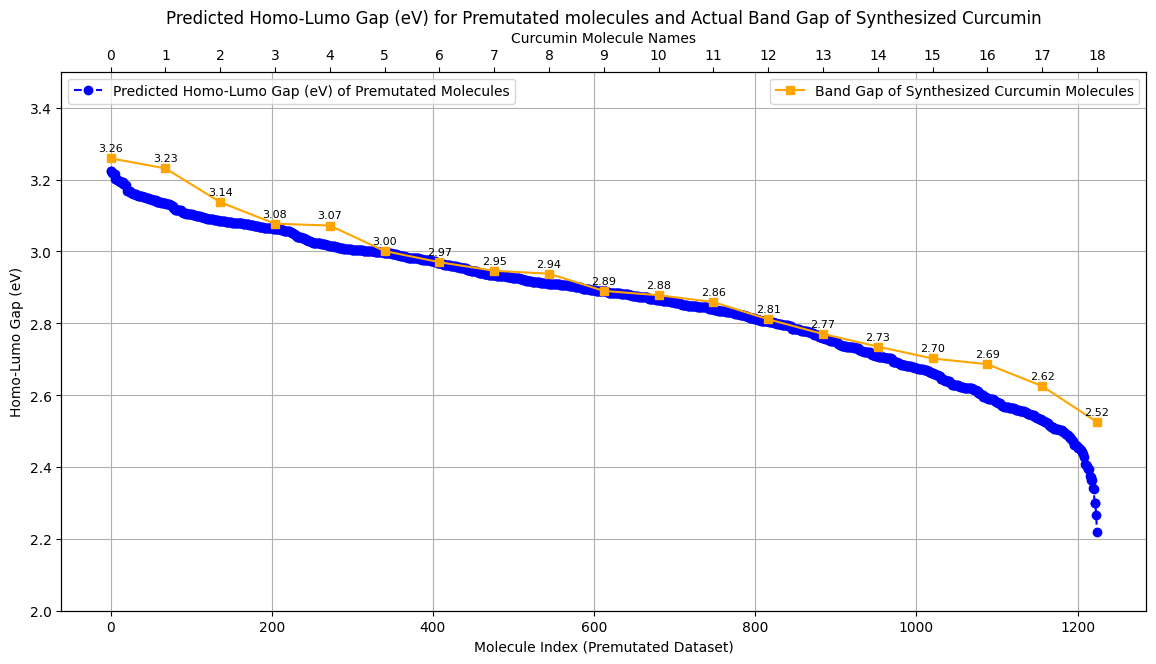

In [9]:
import matplotlib.pyplot as plt

# Create the main figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot `Premutated_Mol_df_mf` Homo-Lumo Gap Prediction on the primary axis
ax1.plot(Premutated_Mol_df_mf['Homo-Lumo Gap (eV) Pred'], label='Predicted Homo-Lumo Gap (eV) of Premutated Molecules', marker='o', linestyle='--', color='blue')
ax1.set_xlabel('Molecule Index (Premutated Dataset)')
ax1.set_ylabel('Homo-Lumo Gap (eV)')
ax1.set_ylim(2.0, 3.5)
ax1.legend(loc='upper left')
ax1.grid(True)

# Secondary x-axis for displaying the entire `curcumin_df_mf` dataset
ax2 = ax1.twiny()
ax2.plot(range(len(curcumin_df_mf)), curcumin_df_mf['Homo-Lumo Gap (eV)'], label='Band Gap of Synthesized Curcumin Molecules', marker='s', color='orange')
ax2.set_xticks(range(len(curcumin_df_mf)))  # Set x-ticks to cover all curcumin molecules
ax2.set_xlabel('Curcumin Molecule Names')
ax2.legend(loc='upper right')

for i, value in enumerate(curcumin_df_mf['Homo-Lumo Gap (eV)']):
    ax2.annotate(f"{value:.2f}", (i, value), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

# Set the title
plt.title('Predicted Homo-Lumo Gap (eV) for Premutated molecules and Actual Band Gap of Synthesized Curcumin')
plt.show()

In [28]:
from rdkit import Chem
from rdkit.Chem import Draw
df = Premutated_Mol_df_mf.head(6)
for i, row in df.iterrows():
    molecule = Chem.MolFromSmiles(row['Combined SMILES'])
    img = Draw.MolToImage(molecule, size=(700, 700))
    img.show()

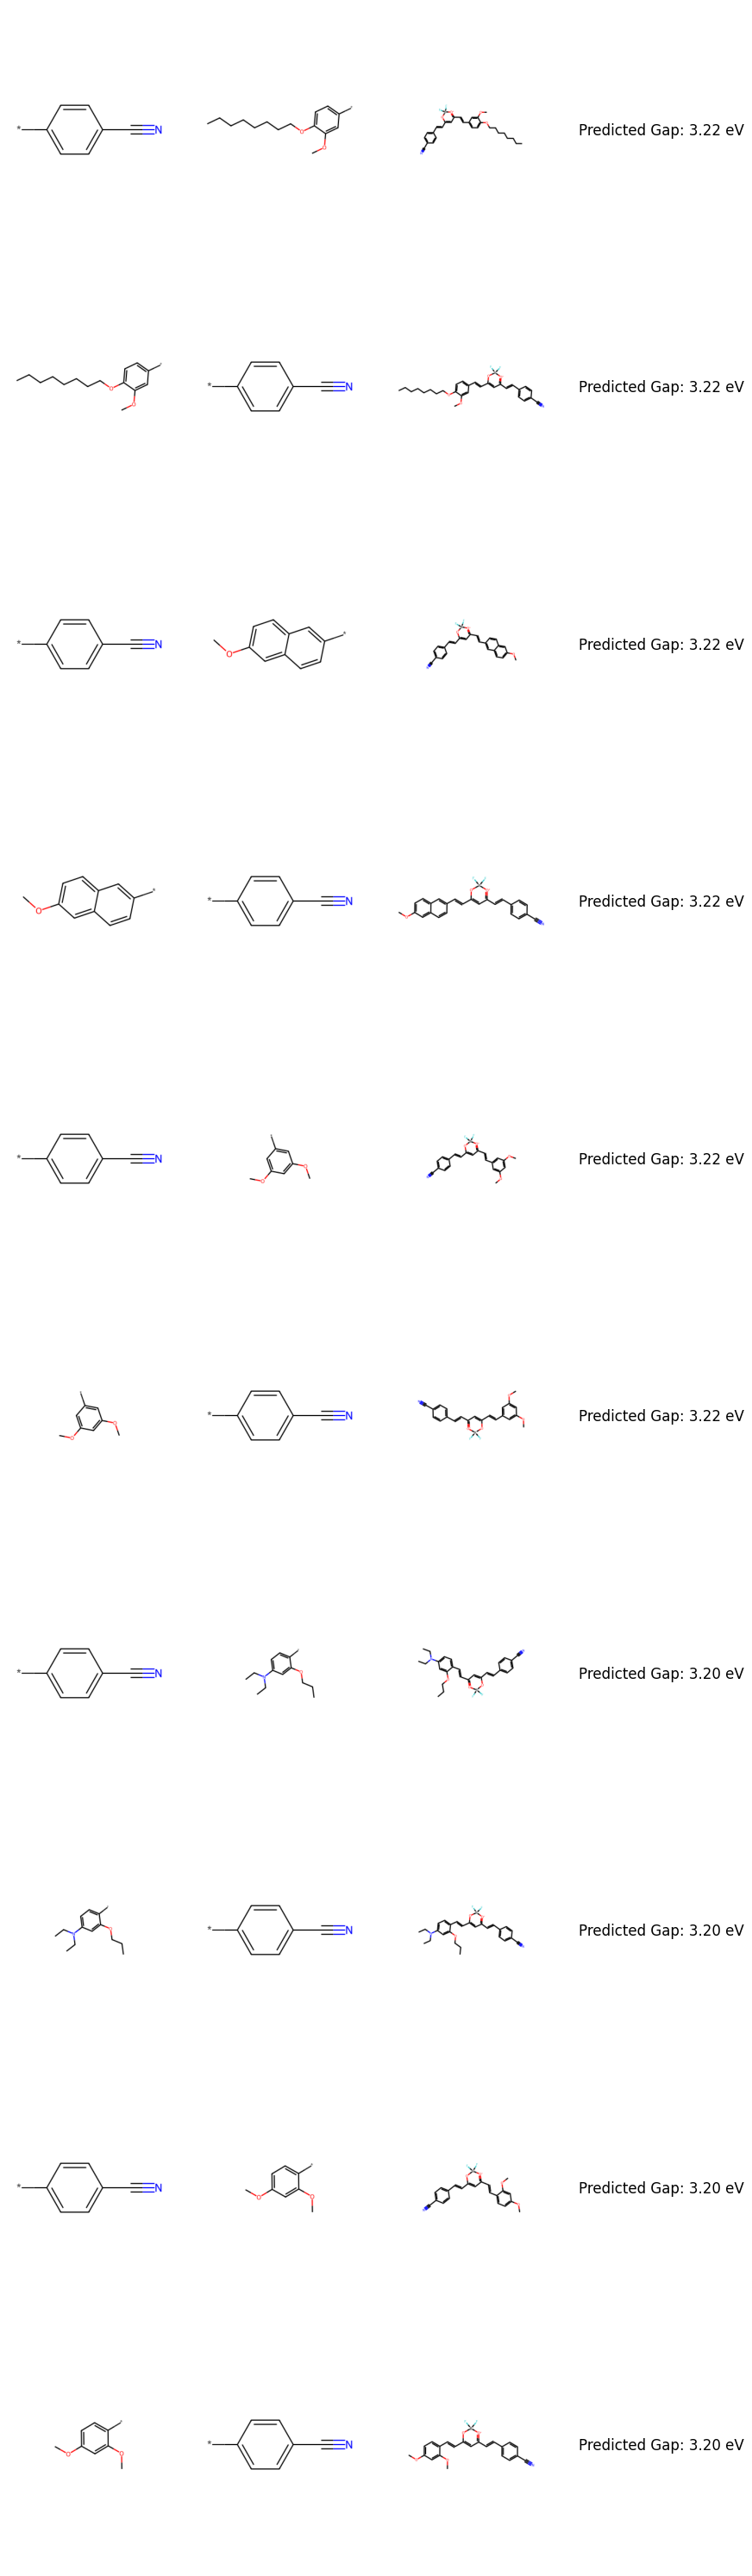

In [15]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

# Load your dataframe
# Assuming 'Premutated_Mol_df_mf' is already loaded as a DataFrame
df = Premutated_Mol_df_mf.head(10)

# Function to generate molecule images
def draw_molecule_grid(df, n_cols=3):
    # Calculate grid dimensions
    n_rows = len(df)
    fig, axes = plt.subplots(n_rows, n_cols+1, figsize=(n_cols*3, n_rows*3))
    
    # Loop through each row in the DataFrame
    for i, row in df.iterrows():
        # Extract SMILES and convert to RDKit Mol objects
        side1_mol = Chem.MolFromSmiles(row['Side Group 1 SMILES'])
        side2_mol = Chem.MolFromSmiles(row['Side Group 2 SMILES'])
        combined_mol = Chem.MolFromSmiles(row['Combined SMILES'])
        
        # Draw each molecule in the corresponding cell
        for j, mol in enumerate([side1_mol, side2_mol, combined_mol]):
            if mol:
                img = Draw.MolToImage(mol, size=(300, 100))
                axes[i, j].imshow(img)
            axes[i, j].axis('off')
        
        # Display the predicted band gap
        gap_text = f"Predicted Gap: {row['Homo-Lumo Gap (eV) Pred']:.2f} eV"
        axes[i, n_cols].text(0.5, 0.5, gap_text, ha='center', va='center', fontsize=12)
        axes[i, n_cols].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
draw_molecule_grid(df)

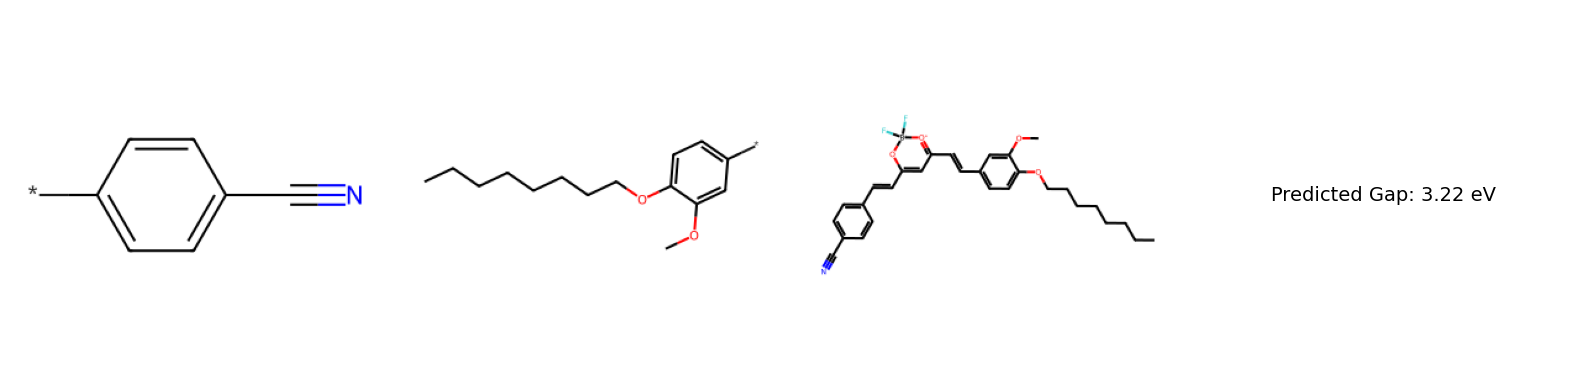

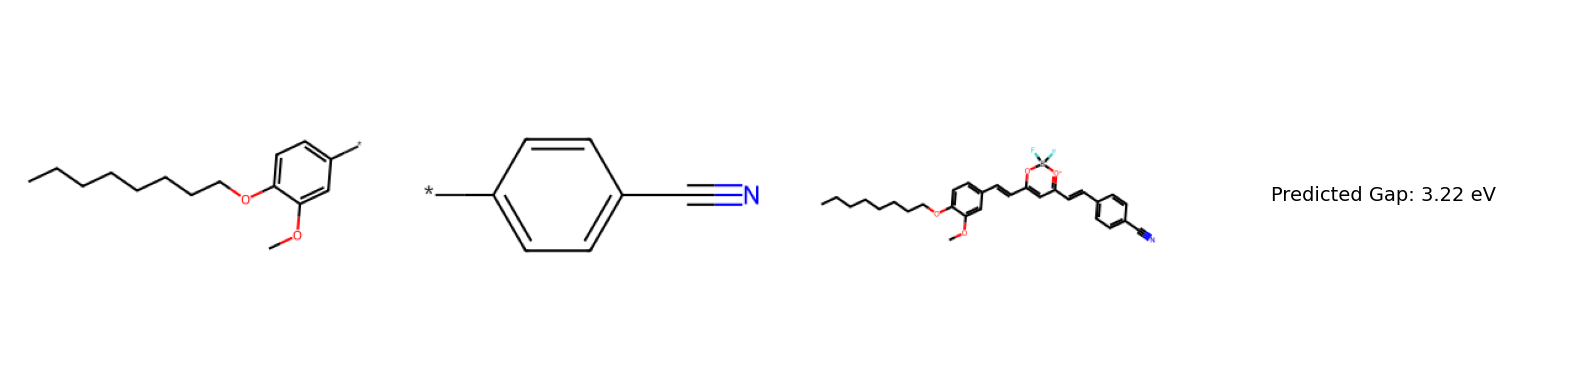

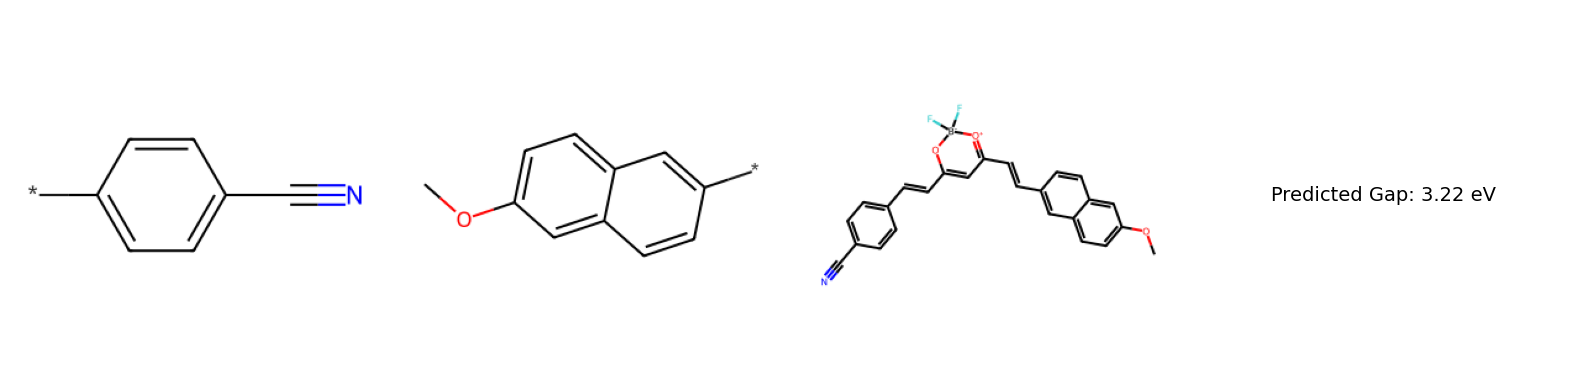

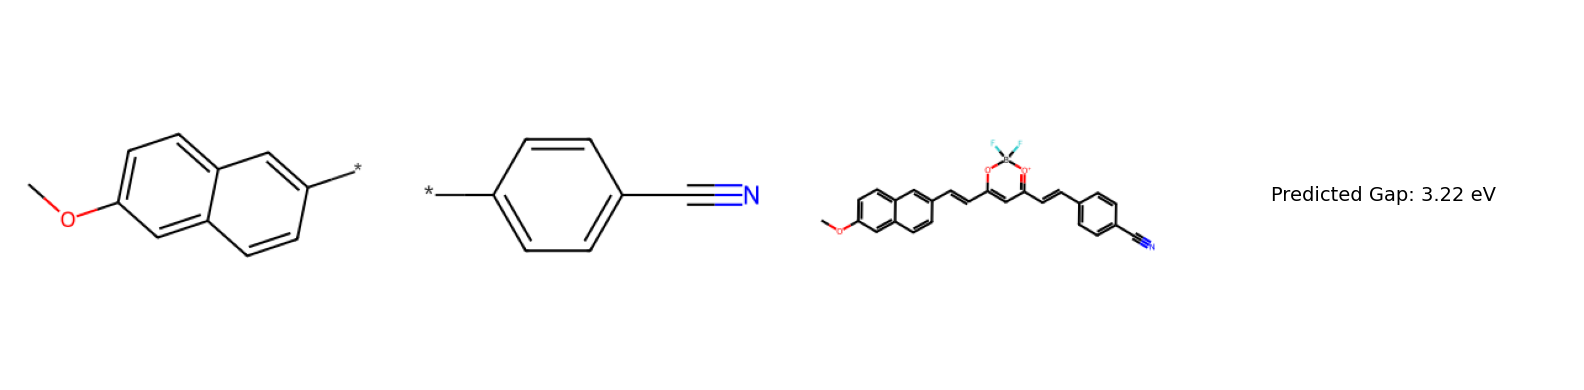

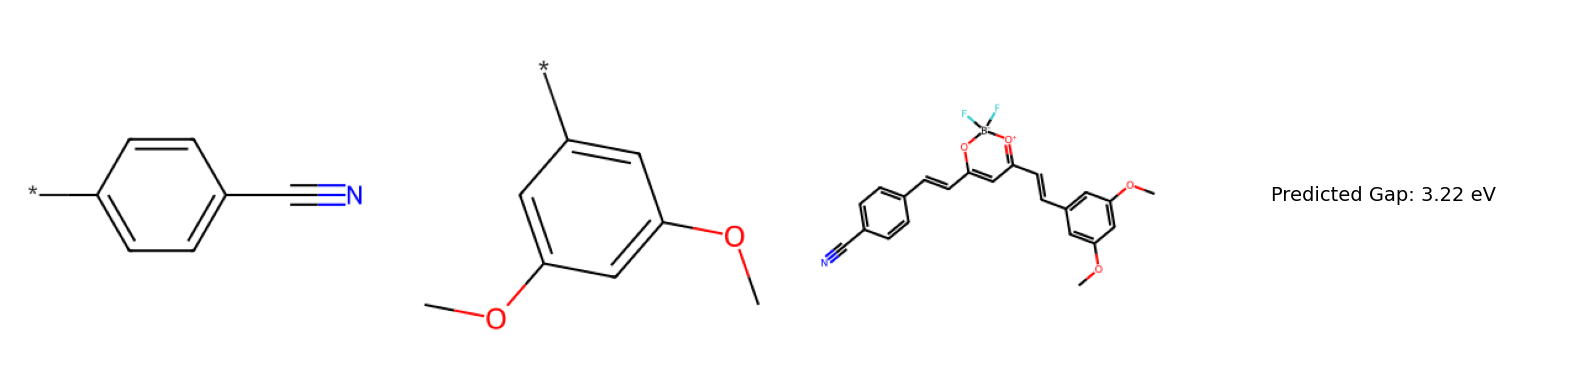

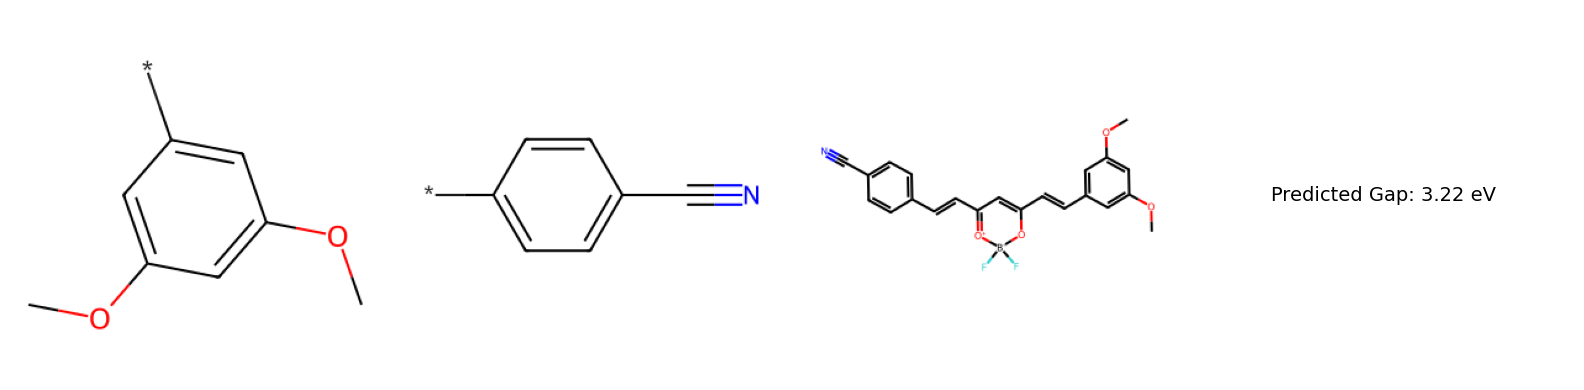

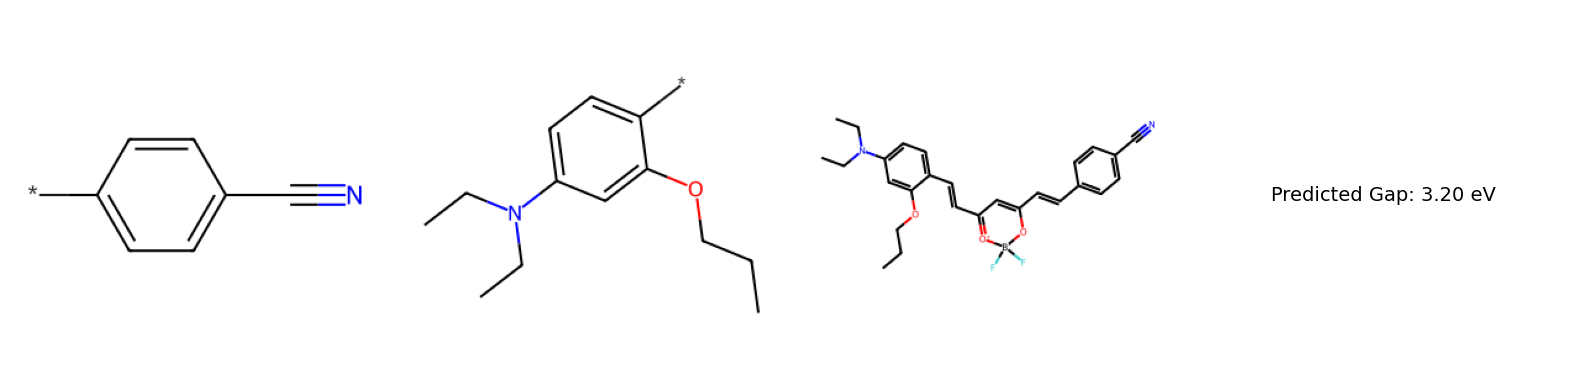

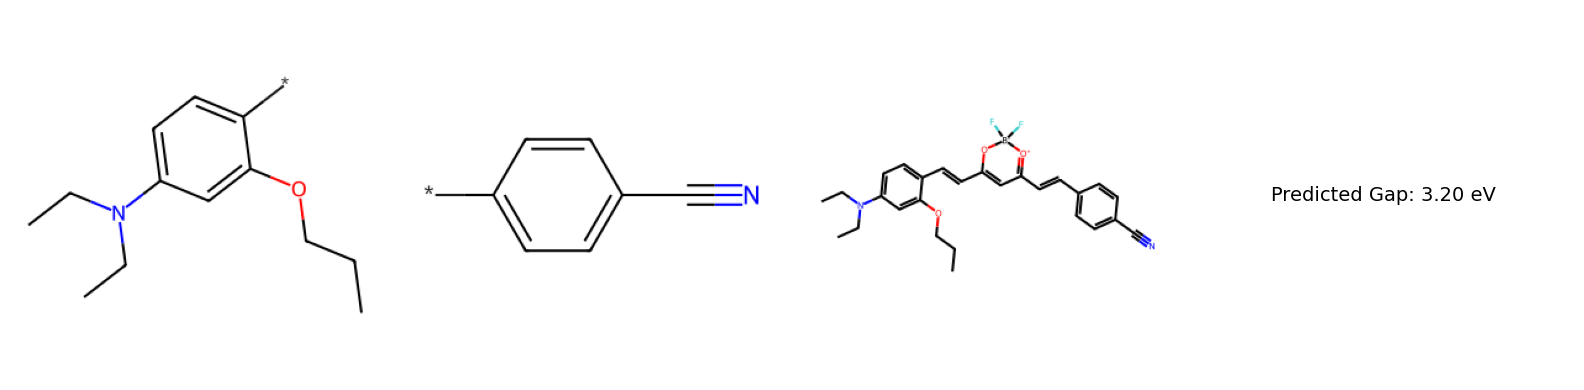

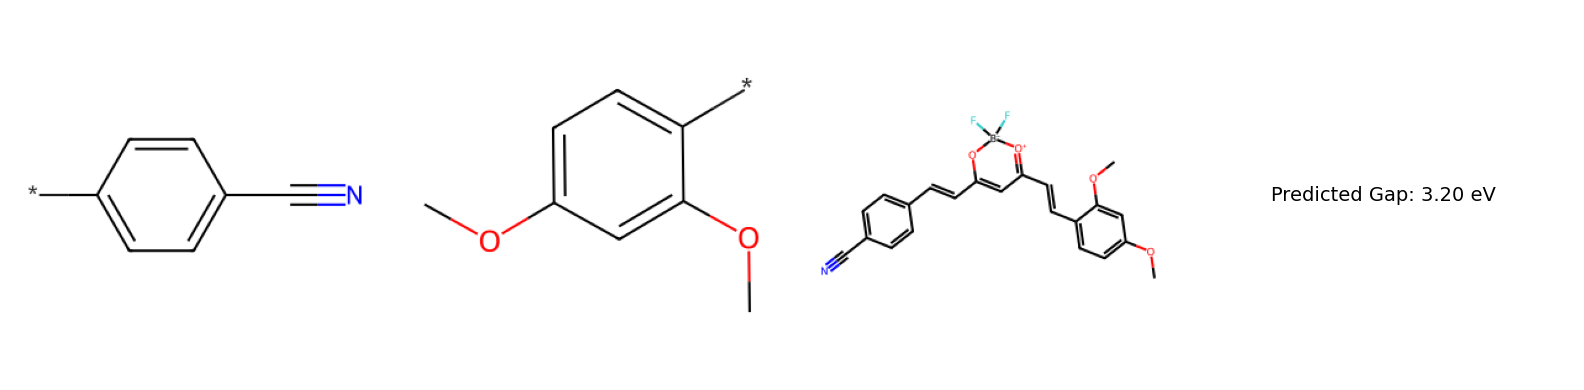

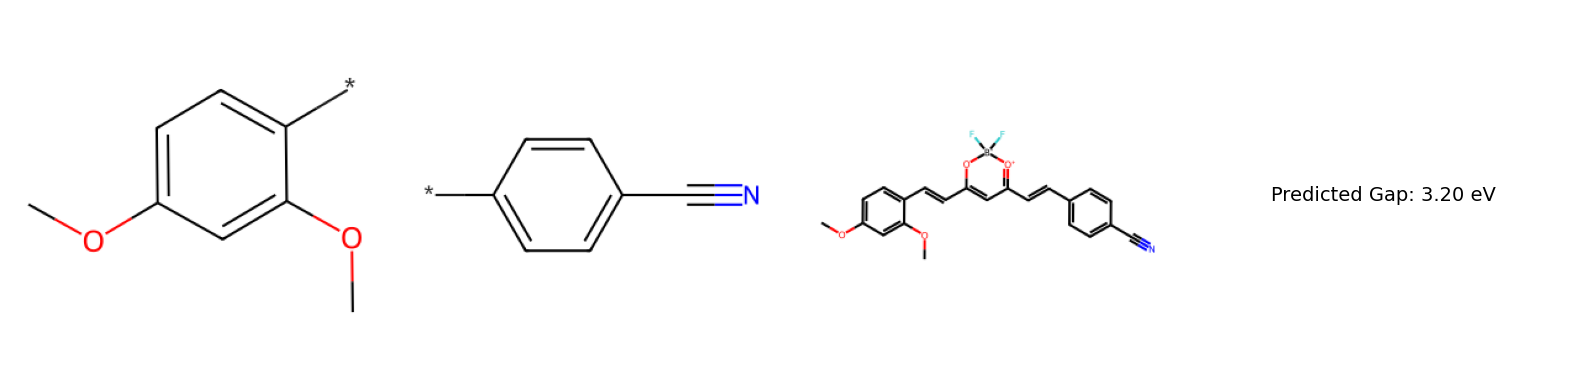

In [16]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

# Load your dataframe
# Assuming 'Premutated_Mol_df_mf' is already loaded as a DataFrame
df = Premutated_Mol_df_mf.head(10)  # Select only the top 10 rows

# Function to generate individual plots for each row
def plot_individual_molecules(df):
    for i, row in df.iterrows():
        # Extract SMILES and convert to RDKit Mol objects
        side1_mol = Chem.MolFromSmiles(row['Side Group 1 SMILES'])
        side2_mol = Chem.MolFromSmiles(row['Side Group 2 SMILES'])
        combined_mol = Chem.MolFromSmiles(row['Combined SMILES'])
        
        # Set up a figure with 4 columns
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        # Draw each molecule in the corresponding cell
        for j, mol in enumerate([side1_mol, side2_mol, combined_mol]):
            if mol:
                img = Draw.MolToImage(mol, size=(300, 300))
                axes[j].imshow(img)
            axes[j].axis('off')
        
        # Display the predicted band gap
        gap_text = f"Predicted Gap: {row['Homo-Lumo Gap (eV) Pred']:.2f} eV"
        axes[3].text(0.5, 0.5, gap_text, ha='center', va='center', fontsize=14)
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.show()

# Call the function with your DataFrame
plot_individual_molecules(df)